# **Predictive Analysis #3**

>***UC-Irvine Online Shoppers Purchasing Intention Dataset***

In Predictive Analysis#1 we used all 17 available independent variables, In Predictive Analysis#2 we used 14 independent variables in the machine learning models. In this step, we will apply another feature selection method: ***Information Gain*** alongside corrolation.

#Importing libraries and dataset

**Importing required libraries**

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import copy

from sklearn.utils import indexable, check_random_state, shuffle
from pandas.core.frame import DataFrame
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier, plot_tree
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import plot_confusion_matrix


**Reading the dataset to Pandas dataframe**

In [117]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv"
df_original = pd.read_csv (url)

#Feature Selection

**In this section we will create a copy of original dataset, prepare the data, and apply feature selection.This copy will only will be used for feature selection, and not in any modelling**

In [118]:
df_extra= df_original.copy()

**Data Normalization**

In [119]:
from sklearn.preprocessing import Normalizer
#defining the preprocessor 
Normalizer=Normalizer()

#creating a list of numerical features 
numeric_features = ["Administrative", "Administrative_Duration", 
                    "Informational", "Informational_Duration", "ProductRelated",
                     "ProductRelated_Duration", "BounceRates", 
                    "ExitRates", "PageValues", "SpecialDay", 
                    "Browser","Region", "OperatingSystems","TrafficType"  ]

#normalizing the numerical features 
df_extra[numeric_features]=Normalizer.fit_transform(df_extra[numeric_features])

**Creating a temporary dataframe from only the dependent variable so it can be re-added as the last column of the finalized dataframe**

In [120]:
y=df_extra[["Revenue"]]

**Transforming the non-numeric categorical features to dummy variables**

In [121]:
#Defining dummy values for all non-numeric  categorical variables 
Month=pd.get_dummies(df_extra["Month"], drop_first=True)
VisitorType=pd.get_dummies(df_extra["VisitorType"], drop_first=True)
Weekend=pd.get_dummies(df_extra["Weekend"],  prefix="Weekend", drop_first=True)

**Dropping the original variables, and dependent variable (so it can be added back as the last column)**

In [122]:
#dropping the original variables, and dependent variable (so it can be added back as the last column)
df_extra.drop(["Month", "VisitorType", "Weekend", "Revenue"], axis=1, inplace=True)

**Adding the newly created dummy variables to the dataset, and adding dependent variable to the end**

In [123]:
#adding the newly created dummy variables to the dataset, and adding dependent variable to the end
df_extra=pd.concat([df_extra, Month, VisitorType, Weekend, y],axis=1)

**Let's take a look at the transformed dataset before we proceed**

In [124]:
df_extra

Administrative  Administrative_Duration  Informational  \
0            0.000000                 0.000000            0.0   
1            0.000000                 0.000000            0.0   
2            0.000000                 0.000000            0.0   
3            0.000000                 0.000000            0.0   
4            0.000000                 0.000000            0.0   
...               ...                      ...            ...   
12325        0.001675                 0.080982            0.0   
12326        0.000000                 0.000000            0.0   
12327        0.000000                 0.000000            0.0   
12328        0.011281                 0.211524            0.0   
12329        0.000000                 0.000000            0.0   

       Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                         0.0        0.443678                 0.000000   
1                         0.0        0.031185                 0.997930   
2                         0.0        0.096189                 0.000000   
3                         0.0        0.301056                 0.401408   
4                         0.0        0.015934                 0.999829   
...                       ...             ...                      ...   
12325                     0.0        0.029600                 0.996243   
12326                     0.0        0.010733                 0.999763   
12327                     0.0        0.032460                 0.996790   
12328                     0.0        0.042305                 0.975829   
12329                     0.0        0.137136                 0.971376   

       BounceRates  ExitRates  PageValues  SpecialDay  ...  June  Mar  May  \
0         0.088736   0.088736    0.000000         0.0  ...     0    0    0   
1         0.000000   0.001559    0.000000         0.0  ...     0    0    0   
2         0.019238   0.019238    0.000000         0.0  ...     0    0    0   
3         0.007526   0.021074    0.000000         0.0  ...     0    0    0   
4         0.000032   0.000080    0.000000         0.0  ...     0    0    0   
...            ...        ...         ...         ...  ...   ...  ...  ...   
12325     0.000004   0.000016    0.006837         0.0  ...     0    0    0   
12326     0.000000   0.000046    0.000000         0.0  ...     0    0    0   
12327     0.000451   0.000469    0.000000         0.0  ...     0    0    0   
12328     0.000000   0.000059    0.000000         0.0  ...     0    0    0   
12329     0.000000   0.003047    0.000000         0.0  ...     0    0    0   

       Nov  Oct  Sep  Other  Returning_Visitor  Weekend_True  Revenue  
0        0    0    0      0                  1             0    False  
1        0    0    0      0                  1             0    False  
2        0    0    0      0                  1             0    False  
3        0    0    0      0                  1             0    False  
4        0    0    0      0                  1             1    False  
...    ...  ...  ...    ...                ...           ...      ...  
12325    0    0    0      0                  1             1    False  
12326    1    0    0      0                  1             1    False  
12327    1    0    0      0                  1             1    False  
12328    1    0    0      0                  1             0    False  
12329    1    0    0      0                  0             1    False  

[12330 rows x 27 columns]

In [125]:
#for "Weekend" we can just replace True and False with 1 & 0 respectively 
df_extra.replace({True:1,False:0})

Administrative  Administrative_Duration  Informational  \
0            0.000000                 0.000000            0.0   
1            0.000000                 0.000000            0.0   
2            0.000000                 0.000000            0.0   
3            0.000000                 0.000000            0.0   
4            0.000000                 0.000000            0.0   
...               ...                      ...            ...   
12325        0.001675                 0.080982            0.0   
12326        0.000000                 0.000000            0.0   
12327        0.000000                 0.000000            0.0   
12328        0.011281                 0.211524            0.0   
12329        0.000000                 0.000000            0.0   

       Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                         0.0        0.443678                 0.000000   
1                         0.0        0.031185                 0.997930   
2                         0.0        0.096189                 0.000000   
3                         0.0        0.301056                 0.401408   
4                         0.0        0.015934                 0.999829   
...                       ...             ...                      ...   
12325                     0.0        0.029600                 0.996243   
12326                     0.0        0.010733                 0.999763   
12327                     0.0        0.032460                 0.996790   
12328                     0.0        0.042305                 0.975829   
12329                     0.0        0.137136                 0.971376   

       BounceRates  ExitRates  PageValues  SpecialDay  ...  June  Mar  May  \
0         0.088736   0.088736    0.000000         0.0  ...     0    0    0   
1         0.000000   0.001559    0.000000         0.0  ...     0    0    0   
2         0.019238   0.019238    0.000000         0.0  ...     0    0    0   
3         0.007526   0.021074    0.000000         0.0  ...     0    0    0   
4         0.000032   0.000080    0.000000         0.0  ...     0    0    0   
...            ...        ...         ...         ...  ...   ...  ...  ...   
12325     0.000004   0.000016    0.006837         0.0  ...     0    0    0   
12326     0.000000   0.000046    0.000000         0.0  ...     0    0    0   
12327     0.000451   0.000469    0.000000         0.0  ...     0    0    0   
12328     0.000000   0.000059    0.000000         0.0  ...     0    0    0   
12329     0.000000   0.003047    0.000000         0.0  ...     0    0    0   

       Nov  Oct  Sep  Other  Returning_Visitor  Weekend_True  Revenue  
0        0    0    0      0                  1             0        0  
1        0    0    0      0                  1             0        0  
2        0    0    0      0                  1             0        0  
3        0    0    0      0                  1             0        0  
4        0    0    0      0                  1             1        0  
...    ...  ...  ...    ...                ...           ...      ...  
12325    0    0    0      0                  1             1        0  
12326    1    0    0      0                  1             1        0  
12327    1    0    0      0                  1             1        0  
12328    1    0    0      0                  1             0        0  
12329    1    0    0      0                  0             1        0  

[12330 rows x 27 columns]

**Now we will apply our feature selection method using Mutual Information for Classification**

In [126]:
from pandas.errors import InvalidIndexError
from numpy.ma.core import ravel
from sklearn.feature_selection import mutual_info_classif
#subsetting the dataset as dependenat and independent variables 
X=df_extra.iloc[:,0:26]
y=df_extra.iloc[:,-1:]
y = y.values.ravel()

#applying feature selection for classification  
importances= mutual_info_classif(X=X,y=y, random_state=37)
feat_importances = pd.Series(importances, df_extra.columns[0:len(df_extra.columns)-1]).sort_values()
#printing the results 
feat_importances

Other                      0.000000
Oct                        0.000000
June                       0.000000
Jul                        0.000000
Dec                        0.000000
Sep                        0.001964
May                        0.002490
Mar                        0.002542
Informational              0.003536
Feb                        0.003651
Weekend_True               0.004919
Nov                        0.006122
Returning_Visitor          0.006219
SpecialDay                 0.007834
ProductRelated_Duration    0.008042
Informational_Duration     0.011620
Administrative             0.019753
ProductRelated             0.020684
Administrative_Duration    0.020888
TrafficType                0.023506
Region                     0.026822
BounceRates                0.026960
Browser                    0.029034
OperatingSystems           0.035864
ExitRates                  0.043146
PageValues                 0.169702
dtype: float64

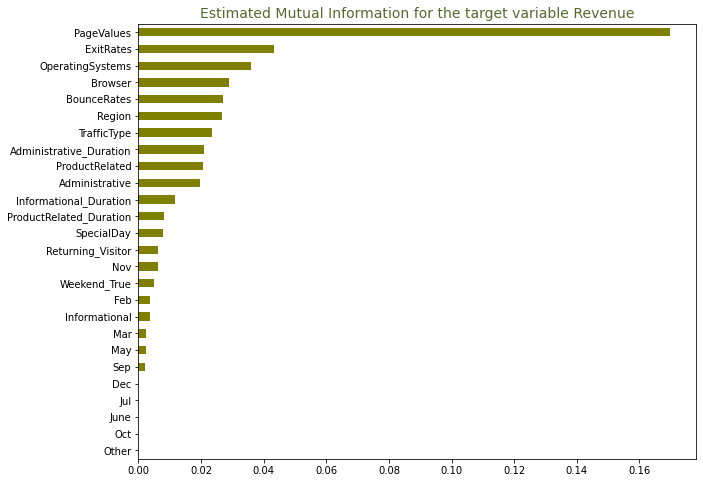

In [127]:
#plotting the results of feature selection 
plt.figure(figsize = (10,8))
feat_importances.plot(kind="barh", color= "olive")
plt.title("Estimated Mutual Information for the target variable Revenue", fontsize=14, color="darkolivegreen")
plt.show()

**By combining the results from Information Gain (setting the treshold at min: 0.01) and Corrolation we remove the following features prior to modelling:**
* **Month**: Removing all except for "Nov" based on IG result
* **VisitorType**: Removing all based on IG result
* **Weekend**: based on IG results
* **Informational**: based on IG results
* **SpecialDay**: based on IG results
* **ProductRelated_Duration**: based on IG results and high Corrolation with "ProductRelated"
* **BounceRates**: The feature was highly coorolated with ExitRates, based on both higher variance and higher mutual information of ExitRates, we remove BounceRates.

# Preprocessing the dataset

**Making a copy to keep the original if needed.**

In [128]:
df_c=df_original.copy()

In [129]:
#defning the list of features to be removed
excluded_features = ["Month", "VisitorType","Weekend",  "Informational", 
                     "SpecialDay", "ProductRelated_Duration", "BounceRates"]

#dropping the above features 
df_c=df_c.drop(columns=excluded_features)

**Data Normalization**

In [130]:
from sklearn.preprocessing import Normalizer
#defining the preprocessor 
Normalizer=Normalizer()

#creating a list of numerical features 
numeric_features = ["Administrative", "Administrative_Duration", 
                    "Informational_Duration", "ProductRelated", 
                    "ExitRates", "PageValues","Browser",
                    "Region", "OperatingSystems","TrafficType"]

#normalizing the numerical features 
df_c[numeric_features]=Normalizer.fit_transform(df_c[numeric_features])


**Let's take a look at the transformed dataset before we proceed**

In [131]:
df_c

Administrative  Administrative_Duration  Informational_Duration  \
0            0.000000                 0.000000                     0.0   
1            0.000000                 0.000000                     0.0   
2            0.000000                 0.000000                     0.0   
3            0.000000                 0.000000                     0.0   
4            0.000000                 0.000000                     0.0   
...               ...                      ...                     ...   
12325        0.019346                 0.935059                     0.0   
12326        0.000000                 0.000000                     0.0   
12327        0.000000                 0.000000                     0.0   
12328        0.051623                 0.967923                     0.0   
12329        0.000000                 0.000000                     0.0   

       ProductRelated  ExitRates  PageValues  OperatingSystems   Browser  \
0            0.445435   0.089087    0.000000          0.445435  0.445435   
1            0.484929   0.024246    0.000000          0.484929  0.484929   
2            0.096207   0.019241    0.000000          0.384829  0.096207   
3            0.328711   0.023010    0.000000          0.493066  0.328711   
4            0.860655   0.004303    0.000000          0.258196  0.258196   
...               ...        ...         ...               ...       ...   
12325        0.341780   0.000187    0.078943          0.025795  0.038692   
12326        0.492664   0.002102    0.000000          0.295598  0.197065   
12327        0.405435   0.005856    0.000000          0.202718  0.135145   
12328        0.193585   0.000272    0.000000          0.025811  0.025811   
12329        0.577303   0.012829    0.000000          0.577303  0.384869   

         Region  TrafficType  Revenue  
0      0.445435     0.445435    False  
1      0.242464     0.484929    False  
2      0.865865     0.288622    False  
3      0.328711     0.657422    False  
4      0.086065     0.344262    False  
...         ...          ...      ...  
12325  0.006449     0.006449    False  
12326  0.098533     0.788262    False  
12327  0.067573     0.878444    False  
12328  0.038717     0.141962    False  
12329  0.192434     0.384869    False  

[12330 rows x 11 columns]

#ML Parameters

* **we set random state for the result to be repeatable**

In [132]:
# Set a Random State 
rng = np.random.RandomState(0)


* **Let's separate our dependent variable, and split our data to train set and test set.** 
* **we will keep this 20% test set to evaluate and compare the performance of  all models.**

In [133]:
from sklearn.model_selection import train_test_split
# Divide X and y (separating dependent variable from independent variables)
y = df_c['Revenue']
X = df_c.drop(['Revenue'], axis=1)

# Split dataset to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=rng)

* **We will use Accuracy,precision, recall, F1 score, and AUC-ROC(Area Under the Curve of Receiver Operating Characteristics) as evaluation measure to compare our models.**
* **We are also using 10 fold cross validation, repeated 3 times, to train our models. Please note we set randm_state to ensure our folds stay the same for all models.**

In [134]:
#creating a list of evaluation measures to pass on to ML pipelines
scoring = ('roc_auc','accuracy','precision','recall', "f1")

#creating repeated K fold Cross validation with random state to pass on to ML pieplines 
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=rng)


**As shown in the EDA, our data set is extremely imbalanced. Hence, we will apply SMOTE on our train dataset before training each model by adding the SMOTE function to all our Machine Learning pieplines.**

#XGB Classifier

**Let's pass on the data to XGB (Extreme Gradient Boosting) Classifier**

In [135]:
#defining the classifier 
XGB=XGBClassifier(eval_metric='logloss', max_depth=27)

#steps in the pipeline 
steps=[('SMOTE', SMOTE(random_state=rng)),("classifier", XGB)]

#defining the pipeline
clf_XGB= Pipeline(steps=steps)

#results from training the model using cross_validation and the predefined pipeline 
scores_XGB = cross_validate(clf_XGB, X_train, y_train, cv=cv, scoring=scoring)

#printing the scores from the result of model training with cross validation
for k, v in scores_XGB.items():
    print(k, np.round(v.mean(),4))


fit_time 9.1033
score_time 0.0695
test_roc_auc 0.8841
test_accuracy 0.8704
test_precision 0.5534
test_recall 0.732
test_f1 0.6297


* **We see the evaluation on our training dataset.**

**In the next step, we pass on the test set to our model, and calculate the evaluation measures using the test set which would be the measures to compare the performance of the models** 

In [136]:
#Fit the model on the Training set (loading the model) before calling the model for prediction
XGB_fit=XGB.fit(X_train, y_train)


**Predicting the independent variable "Revenue" using test set**

In [137]:
#predicting the independent variable "Revenue" using the fitted piepline! :)
y_pred_XGB = XGB_fit.predict(X_test)

**Displaying the results as Confusion Matrix**

In [138]:
from sklearn.metrics import confusion_matrix, accuracy_score
# Confusion Matrix
cm_XGB=confusion_matrix(y_test, y_pred_XGB)
cm_XGB

array([[1953,   91],
       [ 202,  220]])

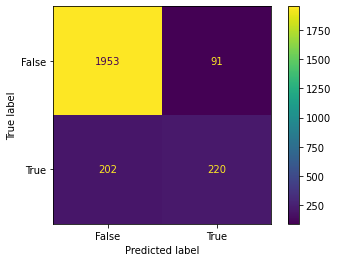

In [139]:
from sklearn.metrics import ConfusionMatrixDisplay
#Displaying the results of Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_XGB);

**Let's get the evaluation measures for the model:**

In [140]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
#getting the evaluation measures for test set
XGB_Metrics= classification_report(y_test, y_pred_XGB, digits=3)
XGB_ROC_AUC= round(roc_auc_score(y_test, y_pred_XGB),3)

#printing the evaluation measures for test set
print("XGBClassifier\n\n", XGB_Metrics)
print("roc_auc    ", XGB_ROC_AUC )

XGBClassifier

               precision    recall  f1-score   support

       False      0.906     0.955     0.930      2044
        True      0.707     0.521     0.600       422

    accuracy                          0.881      2466
   macro avg      0.807     0.738     0.765      2466
weighted avg      0.872     0.881     0.874      2466

roc_auc     0.738


**Saving the model performance result in a dictionary**

In [141]:
#saving the model performance result in a dictionary for easy future access
XGB_report= classification_report(y_test, y_pred_XGB, digits=3, output_dict=True)


**NOTE: All the above steps will be repeated for each model.**

**For this model, let's plot the XGB tree!**

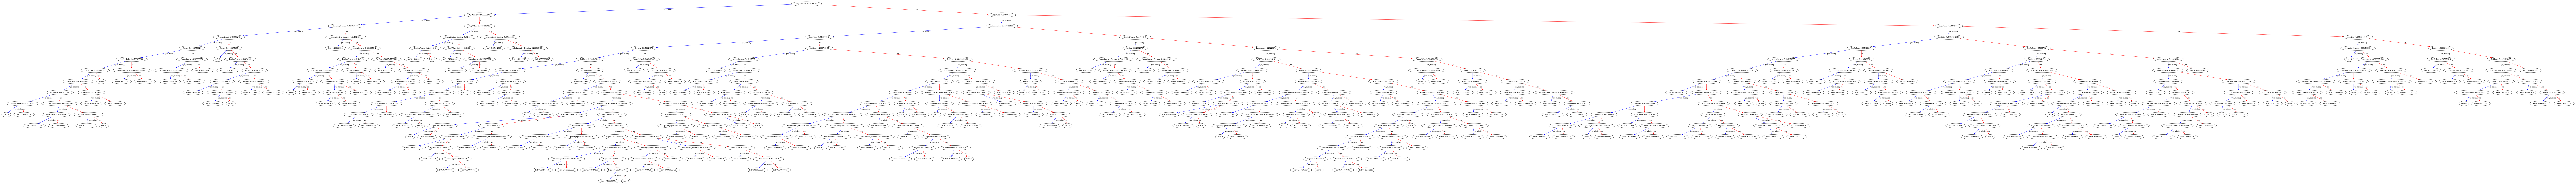

In [142]:
from xgboost import plot_tree
#Plotting the XGB tree
plot_tree(XGB);
fig = plt.gcf()
fig.set_size_inches(300, 300)
fig.savefig('XGBtree.png')

#Random Forest Classifier

In [143]:
from sklearn.ensemble import RandomForestClassifier

#defining the classifier 
RF=RandomForestClassifier(random_state=rng)

#steps in the pipeline 
steps=[('SMOTE', SMOTE(random_state=rng)),("classifier", RF)]

#defining the pipeline
clf_RF= Pipeline(steps=steps)

#results from training the model using cross_validation and the predefined pipeline 
scores_RF = cross_validate(clf_RF, X_train, y_train, cv=cv, scoring=scoring)

#printing the scores from the result of model training with cross validation
for k, v in scores_RF.items():
    print(k, np.round(v.mean(),4))

fit_time 4.0767
score_time 0.0829
test_roc_auc 0.89
test_accuracy 0.8733
test_precision 0.5583
test_recall 0.763
test_f1 0.6442


In [144]:
#Fit the model on the Training set (loading the model) before calling the model for prediction
RF_fit=RF.fit(X_train, y_train)

In [145]:
#predicting the independent variable "Revenue" using the fitted piepline! :)
y_pred_RF = RF_fit.predict(X_test)

In [146]:
# Confusion Matrix
cm_RF=confusion_matrix(y_test, y_pred_RF)
cm_RF

array([[1960,   84],
       [ 197,  225]])

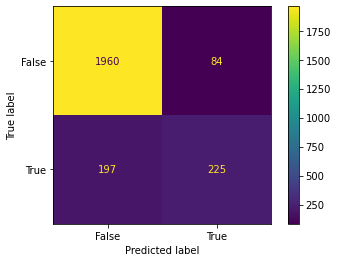

In [147]:
#Displaying the results of Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_RF);

In [148]:
#getting the evaluation measures for test set
RF_Metrics= classification_report(y_test, y_pred_RF, digits=3)
RF_ROC_AUC= round(roc_auc_score(y_test, y_pred_RF),3)

#printing the evaluation measures for test set
print("RandomForestClassifier\n\n", RF_Metrics)
print("roc_auc    ", RF_ROC_AUC )

RandomForestClassifier

               precision    recall  f1-score   support

       False      0.909     0.959     0.933      2044
        True      0.728     0.533     0.616       422

    accuracy                          0.886      2466
   macro avg      0.818     0.746     0.774      2466
weighted avg      0.878     0.886     0.879      2466

roc_auc     0.746


In [149]:
#saving the model performance result in a dictionary for easy future access
RF_report= classification_report(y_test, y_pred_RF, digits=3, output_dict=True)

#Desicion Tree Classifier

In [150]:
#defining the classifier 
DT=DecisionTreeClassifier(random_state=rng)

#steps in the pipeline 
steps=[('SMOTE', SMOTE(random_state=rng)),("classifier", DT)]

#defining the pipeline
clf_DT= Pipeline(steps=steps)

#results from training the model using cross_validation and the predefined pipeline 
scores_DT = cross_validate(clf_DT, X_train, y_train, cv=cv, scoring=scoring)

#printing the scores from the result of model training with cross validation
for k, v in scores_DT.items():
    print(k, np.round(v.mean(),4))

fit_time 0.227
score_time 0.0101
test_roc_auc 0.7465
test_accuracy 0.8274
test_precision 0.4481
test_recall 0.6314
test_f1 0.5235


In [151]:
#Fit the model on the Training set (loading the model) before calling the model for prediction
DT_fit= DT.fit(X_train, y_train)


In [152]:
#predicting the independent variable "Revenue" using the fitted piepline! :)
y_pred_DT = DT_fit.predict(X_test)

In [153]:
# Confusion Matrix
cm_DT=confusion_matrix(y_test, y_pred_DT)
cm_DT

array([[1863,  181],
       [ 210,  212]])

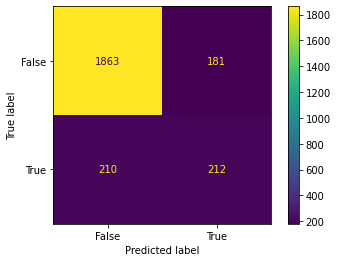

In [154]:
#Displaying the results of Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_DT);

In [155]:
#getting the evaluation measures for test set
DT_Metrics= classification_report(y_test, y_pred_DT, digits=3)
DT_ROC_AUC= round(roc_auc_score(y_test, y_pred_DT),3)

#printing the evaluation measures for test set
print("DecisionTreeClassifier\n\n", DT_Metrics)
print("roc_auc    ", DT_ROC_AUC )

DecisionTreeClassifier

               precision    recall  f1-score   support

       False      0.899     0.911     0.905      2044
        True      0.539     0.502     0.520       422

    accuracy                          0.841      2466
   macro avg      0.719     0.707     0.713      2466
weighted avg      0.837     0.841     0.839      2466

roc_auc     0.707


In [156]:
#saving the model performance result in a dictionary for easy future access
DT_report= classification_report(y_test, y_pred_DT, digits=3, output_dict=True)

#Support Vector Classification

In [157]:
from sklearn import svm

#defining the classifier 
SVC_L=svm.SVC(kernel='linear', random_state=rng)

#steps in the pipeline 
steps=[('SMOTE', SMOTE(random_state=rng)),("classifier", SVC_L)]

#defining the pipeline
clf_SVC_L= Pipeline(steps=steps)

#results from training the model using cross_validation and the predefined pipeline 
scores_SVC_L = cross_validate(clf_SVC_L, X_train, y_train, cv=cv, scoring=scoring)

#printing the scores from the result of model training with cross validation
for k, v in scores_SVC_L.items():
    print(k, np.round(v.mean(),4))

fit_time 5.366
score_time 0.4083
test_roc_auc 0.8703
test_accuracy 0.8433
test_precision 0.4863
test_recall 0.6742
test_f1 0.5643


In [158]:
#Fit the model on the Training set (loading the model) before calling the model for prediction
SVC_fit=SVC_L.fit(X_train, y_train)


In [159]:
#predicting the independent variable "Revenue" using the fitted piepline! :)
y_pred_SVC_L = SVC_fit.predict(X_test)

In [160]:
# Confusion Matrix
cm_SVC_L=confusion_matrix(y_test, y_pred_SVC_L)
cm_SVC_L

array([[2000,   44],
       [ 273,  149]])

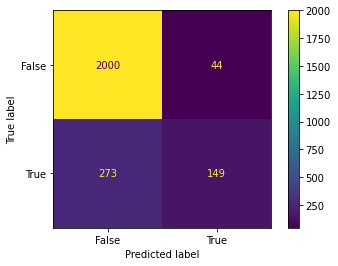

In [161]:
#Displaying the results of Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_SVC_L);

In [162]:
#getting the evaluation measures for test set
SVC_L_Metrics= classification_report(y_test, y_pred_SVC_L, digits=3)
SVC_L_ROC_AUC= round(roc_auc_score(y_test, y_pred_SVC_L),3)

#printing the evaluation measures for test set
print("Support Vector Classification \n\n", SVC_L_Metrics)
print("roc_auc    ", SVC_L_ROC_AUC )

Support Vector Classification 

               precision    recall  f1-score   support

       False      0.880     0.978     0.927      2044
        True      0.772     0.353     0.485       422

    accuracy                          0.871      2466
   macro avg      0.826     0.666     0.706      2466
weighted avg      0.861     0.871     0.851      2466

roc_auc     0.666


In [163]:
#saving the model performance result in a dictionary for easy future access
SVC_L_report= classification_report(y_test, y_pred_SVC_L, digits=3, output_dict=True)

#LogisticRegression

In [164]:
from sklearn.linear_model import LogisticRegression

#defining the classifier 
LR=LogisticRegression(random_state=rng, max_iter=2000)

#steps in the pipeline 
steps=[('SMOTE', SMOTE( random_state=rng)),("classifier", LR)]

#defining the pipeline
clf_LR= Pipeline(steps=steps)

#results from training the model using cross_validation and the predefined pipeline 
scores_LR = cross_validate(clf_LR, X_train, y_train, cv=cv, scoring=scoring)

#printing the scores from the result of model training with cross validation
for k, v in scores_LR.items():
    print(k, np.round(v.mean(),4))

fit_time 0.2064
score_time 0.0138
test_roc_auc 0.884
test_accuracy 0.8332
test_precision 0.4684
test_recall 0.7806
test_f1 0.5846


In [165]:
#Fit the model on the Training set (loading the model) before calling the model for prediction
LR_fit=LR.fit(X_train, y_train)

In [166]:
#predicting the independent variable "Revenue" using the fitted piepline! :)
y_pred_LR = LR_fit.predict(X_test)

In [167]:
# Confusion Matrix
cm_LR=confusion_matrix(y_test, y_pred_LR)
cm_LR

array([[1998,   46],
       [ 276,  146]])

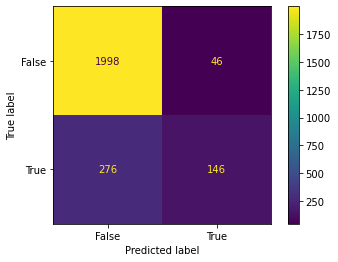

In [168]:
#Displaying the results of Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_LR);

In [169]:
#getting the evaluation measures for test set
LR_Metrics= classification_report(y_test, y_pred_LR, digits=3)
LR_ROC_AUC= round(roc_auc_score(y_test, y_pred_LR),3)

#printing the evaluation measures for test set
print("Logistic Regression Classifier \n\n", LR_Metrics)
print("roc_auc    ", LR_ROC_AUC )

Logistic Regression Classifier 

               precision    recall  f1-score   support

       False      0.879     0.977     0.925      2044
        True      0.760     0.346     0.476       422

    accuracy                          0.869      2466
   macro avg      0.820     0.662     0.700      2466
weighted avg      0.858     0.869     0.848      2466

roc_auc     0.662


In [170]:
#saving the model performance result in a dictionary for easy future access
LR_report= classification_report(y_test, y_pred_LR, digits=3, output_dict=True)

#Comparing the Models 

In [171]:
from tabulate import tabulate

In [172]:
#create data
data = [["Extreme Gradiant Boosting", XGB_report["accuracy"], XGB_report["False"]["recall"], XGB_report["True"]["recall"], 
         XGB_report["False"]["precision"], XGB_report["True"]["precision"], XGB_report["False"]["f1-score"], XGB_report["True"]["f1-score"], XGB_ROC_AUC],
        
        ["Random Forest", RF_report["accuracy"], RF_report["False"]["recall"], RF_report["True"]["recall"], 
         RF_report["False"]["precision"], RF_report["True"]["precision"], RF_report["False"]["f1-score"], RF_report["True"]["f1-score"], RF_ROC_AUC], 
        
        ["Decision Tree", DT_report["accuracy"], DT_report["False"]["recall"], DT_report["True"]["recall"], 
         DT_report["False"]["precision"], DT_report["True"]["precision"], DT_report["False"]["f1-score"], DT_report["True"]["f1-score"], DT_ROC_AUC], 
        
        ["Support Vector Classifier", SVC_L_report["accuracy"], SVC_L_report["False"]["recall"], SVC_L_report["True"]["recall"], 
         SVC_L_report['False']["precision"], SVC_L_report["True"]["precision"], SVC_L_report["False"]["f1-score"], SVC_L_report["True"]["f1-score"], SVC_L_ROC_AUC],
        
        ["Logistic Regression", LR_report["accuracy"], LR_report["False"]["recall"], LR_report["True"]["recall"], 
         LR_report["False"]["precision"], LR_report["True"]["precision"], LR_report["False"]["f1-score"], LR_report["True"]["f1-score"], LR_ROC_AUC]]
  
#define header names
col_names = ["Classifier", "Accuracy", "Recall (Revenue=False)", "Recall (Revenue=True)", "Precision (Revenue=False)",
             "Precision (Revenue=True)", "F1 (Revenue=False)", "F1 (Revenue=True)", "ROC_AUC"]
  
#display table
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))


╒═══════════════════════════╤════════════╤══════════════════════════╤═════════════════════════╤═════════════════════════════╤════════════════════════════╤══════════════════════╤═════════════════════╤═══════════╕
│ Classifier                │   Accuracy │   Recall (Revenue=False) │   Recall (Revenue=True) │   Precision (Revenue=False) │   Precision (Revenue=True) │   F1 (Revenue=False) │   F1 (Revenue=True) │   ROC_AUC │
╞═══════════════════════════╪════════════╪══════════════════════════╪═════════════════════════╪═════════════════════════════╪════════════════════════════╪══════════════════════╪═════════════════════╪═══════════╡
│ Extreme Gradiant Boosting │   0.881184 │                 0.955479 │                0.521327 │                    0.906265 │                   0.707395 │             0.930221 │            0.600273 │     0.738 │
├───────────────────────────┼────────────┼──────────────────────────┼─────────────────────────┼─────────────────────────────┼───────────────────────────

**In this analysis we used 10 independent variables (out of 17 in the original dataset)**

**In the next predictive analysis we will look into another feature selection option with the purpose of improving the performance of our models.**